In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [37]:
file_path = "/Users/mac/Downloads/Jumbo & Company_ Attach % .xls"

df = pd.read_excel(file_path, engine="xlrd")

df.head()

,Branch,Store_Name,Dec,Nov,Oct,Sep,Aug
0,Delhi_Ncr,Delhi(Janakpuri) Br,0.23,0.17,0.16,0.25,0.24
1,Delhi_Ncr,Haryana(Gurgaon) Br,0.21,0.26,0.15,0.28,0.04
2,Delhi_Ncr,Up(Greater Noida) Br,0.25,0.36,0.30,0.41,0.43
3,Pune,Pune(Bhosari) Br,0.33,0.33,0.36,0.13,0.32
4,Gujarat,Ahmedabad(Maninagar) Br,0.19,0.11,0.14,0.21,0.17


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Branch      163 non-null    object 
 1   Store_Name  163 non-null    object 
 2   Dec         163 non-null    float64
 3   Nov         163 non-null    float64
 4   Oct         163 non-null    float64
 5   Sep         163 non-null    float64
 6   Aug         163 non-null    float64
dtypes: float64(5), object(2)
memory usage: 9.0+ KB


In [39]:
# Clean Column Names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns

Index(['branch', 'store_name', 'dec', 'nov', 'oct', 'sep', 'aug'], dtype='object')

In [24]:
# Convert Wide → Long Format
month_cols = ['aug', 'sep', 'oct', 'nov', 'dec']

df_long = df.melt(
    id_vars=['branch', 'store_name'],
    value_vars=month_cols,
    var_name='month',
    value_name='attach_percent'
)

df_long.head()

,branch,store_name,month,attach_percent
0,Delhi_Ncr,Delhi(Janakpuri) Br,aug,0.24
1,Delhi_Ncr,Haryana(Gurgaon) Br,aug,0.04
2,Delhi_Ncr,Up(Greater Noida) Br,aug,0.43
3,Pune,Pune(Bhosari) Br,aug,0.32
4,Gujarat,Ahmedabad(Maninagar) Br,aug,0.17


In [25]:
# Month Mapping
month_map = {
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

df_long['month_num'] = df_long['month'].map(month_map)

df_long.head()

,branch,store_name,month,attach_percent,month_num
0,Delhi_Ncr,Delhi(Janakpuri) Br,aug,0.24,8
1,Delhi_Ncr,Haryana(Gurgaon) Br,aug,0.04,8
2,Delhi_Ncr,Up(Greater Noida) Br,aug,0.43,8
3,Pune,Pune(Bhosari) Br,aug,0.32,8
4,Gujarat,Ahmedabad(Maninagar) Br,aug,0.17,8


In [26]:
# Check Data Quality 
df_long.isnull().sum()

branch            0
store_name        0
month             0
attach_percent    0
month_num         0
dtype: int64

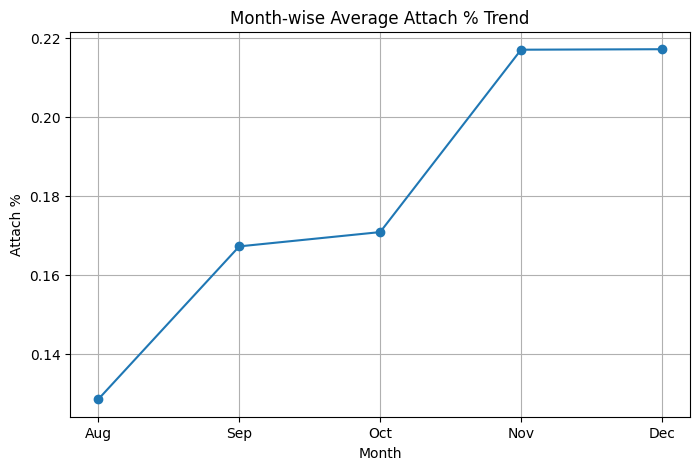

In [27]:
# Month-wise Attach % Trend
monthly_trend = df_long.groupby('month_num')['attach_percent'].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(monthly_trend['month_num'], monthly_trend['attach_percent'], marker='o')
plt.xticks([8,9,10,11,12], ['Aug','Sep','Oct','Nov','Dec'])
plt.title("Month-wise Average Attach % Trend")
plt.xlabel("Month")
plt.ylabel("Attach %")
plt.grid(True)
plt.show()

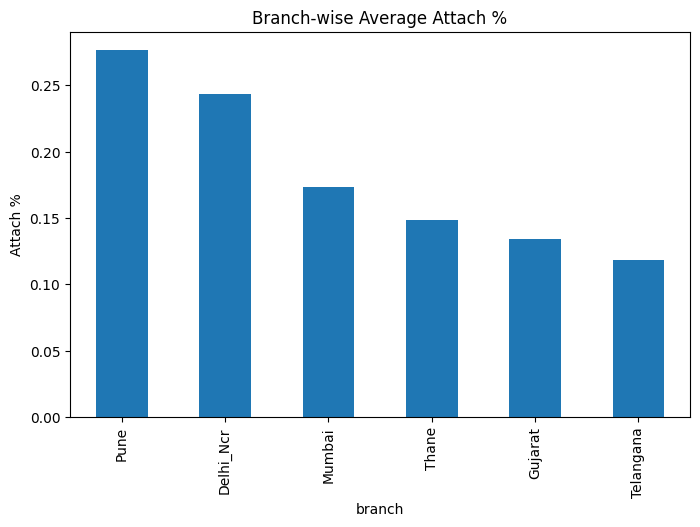

In [28]:
# Branch-wise Performance
branch_perf = (
    df_long.groupby('branch')['attach_percent']
    .mean()
    .sort_values(ascending=False)
)

branch_perf.plot(kind='bar', figsize=(8,5), title="Branch-wise Average Attach %")
plt.ylabel("Attach %")
plt.show()

In [29]:
# Store-wise Performance
store_perf = df_long.groupby('store_name')['attach_percent'].mean().reset_index()
store_perf.sort_values(by='attach_percent', ascending=False).head(10)

,store_name,attach_percent
38,Delhi(Hauz Khas),0.622
96,Pune(Hadapsar),0.586
98,Pune(Kondhawa),0.414
32,Delhi(Budh Vihar),0.390
34,Delhi(Daryaganj),0.386
94,Pune(Dange Chowk),0.368
23,Bhiwandi Br,0.362
47,Delhi(Narela),0.358
71,Haryana(Mewla M.) Br,0.352
153,Up(Greater Noida) Br,0.350


In [30]:
# Store Categorisation
def categorize_store(x):
    if x >= 0.40:
        return "High Performing"
    elif x >= 0.25:
        return "Medium Performing"
    else:
        return "Low Performing"

store_perf['store_category'] = store_perf['attach_percent'].apply(categorize_store)
store_perf['store_category'].value_counts()

store_category
Low Performing       127
Medium Performing     33
High Performing        3
Name: count, dtype: int64

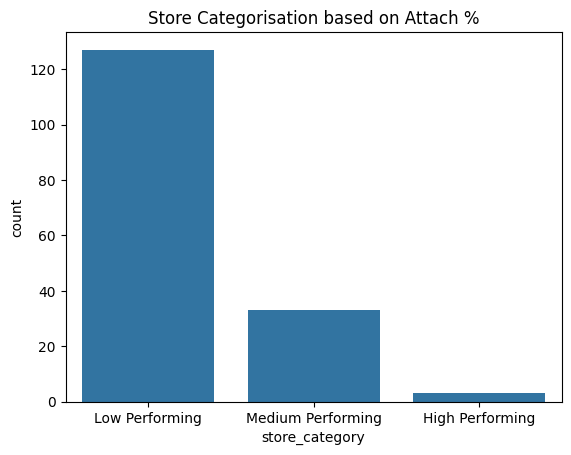

In [31]:
sns.countplot(x='store_category', data=store_perf)
plt.title("Store Categorisation based on Attach %")
plt.show()

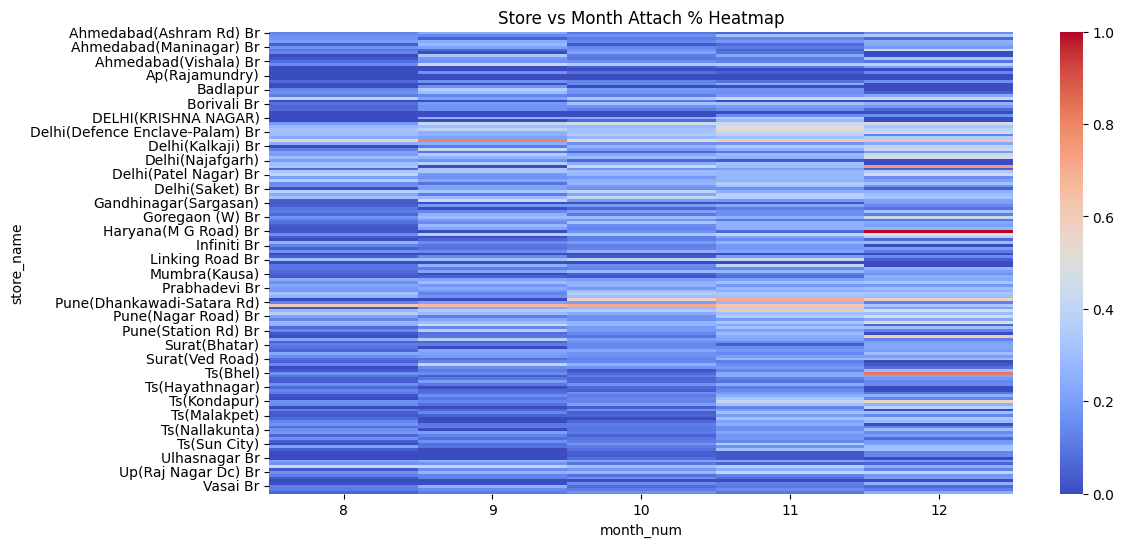

In [32]:
# Store vs Month Heatmap
pivot = df_long.pivot_table(
    values='attach_percent',
    index='store_name',
    columns='month_num',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='coolwarm')
plt.title("Store vs Month Attach % Heatmap")
plt.show()

In [40]:
# January Attach % Prediction (FINAL FIXED)
predictions = []

for store in df_long['store_name'].unique():
    temp = df_long[df_long['store_name'] == store]

    if temp['month_num'].nunique() >= 3:
        X = temp[['month_num']]
        y = temp['attach_percent']

        model = LinearRegression()
        model.fit(X, y)

        jan_pred = model.predict(
            pd.DataFrame({'month_num': [1]})
        )[0]

        # Attach % must be between 0 and 1
        jan_pred = max(0, min(jan_pred, 1))

        predictions.append([store, round(jan_pred, 3)])

jan_pred_df = pd.DataFrame(
    predictions,
    columns=['store_name', 'predicted_attach_jan']
)

jan_pred_df.head()

,store_name,predicted_attach_jan
0,Delhi(Janakpuri) Br,0.300
1,Haryana(Gurgaon) Br,0.000
2,Up(Greater Noida) Br,0.719
3,Pune(Bhosari) Br,0.096
4,Ahmedabad(Maninagar) Br,0.218


In [41]:
# Final Output Merge
final_output = store_perf.merge(
    jan_pred_df,
    on='store_name',
    how='left'
)

final_output.head()

,store_name,attach_percent,store_category,predicted_attach_jan
0,Ahmedabad(Ashram Rd) Br,0.136,Low Performing,0.235
1,Ahmedabad(Bopal),0.224,Low Performing,0.000
2,Ahmedabad(Chandkheda Rd) Br,0.106,Low Performing,0.214
3,Ahmedabad(Dev Arc) Br,0.202,Low Performing,0.166
4,Ahmedabad(Krishna Nagar) Br,0.130,Low Performing,0.000


In [42]:
# save 
final_output.to_excel(
    "Zopper_Final_Attach_Analysis.xlsx",
    index=False
)

In [ ]:
### January Attach % Prediction
January attach % has been predicted at store level using a simple linear regression model
trained on historical month-wise attach % data (August to December).
Predictions are indicative in nature and capture the overall trend direction.